In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Import train_test_split function

#from sklearn.metrics import log_loss
from time import time

import pickle
from sklearn.model_selection import GridSearchCV as GS

plt.rc('font',size=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

import mlrose_hiive
import numpy as np
import pandas as pd
np.random.seed(44)

from IPython.display import display
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=[10,5])
import mlrose_hiive
from sklearn.metrics import f1_score
from functools import partial

from sklearn.metrics import log_loss
from sklearn import metrics
from mlrose_hiive import GeomDecay
from sklearn.preprocessing import StandardScaler
import pickle
from itertools import combinations

# Preparing data

In [ ]:
loss_model = partial(f1_score, average="weighted")


In [13]:
#preparing data
stdsc = StandardScaler()
data_set = pd.read_csv('gender_classification.csv')
data_set['gender'] = (data_set['gender']=='Male').astype(int)




train,test = train_test_split(data_set,test_size=0.2,random_state=1,shuffle=True,stratify =data_set.gender.values)

features = ['long_hair', 'forehead_width_cm', 'forehead_height_cm', 'nose_wide',
       'nose_long', 'lips_thin', 'distance_nose_to_lip_long']
target = 'gender'


X_train= train[features]
y_train = train[target]

X_test= test[features]
y_test = test[target]

stdsc.fit(X_train)


X_train_scaled = pd.DataFrame(stdsc.transform(X_train),columns = features)
X_test_scaled = pd.DataFrame(stdsc.transform(X_test),columns = features)

#data_set_scaled = stdsc.fit_transform(data_set)


In [20]:
seeds = [2693]

# module for finding best model

In [254]:


gd_list['loss_curve'] =dict()

parameter_list   = {'learning_rate' : [0.01,0.002]}  

plt.rcParams.update({'font.size':14})



nn_base_params_gd = dict(hidden_nodes = [68,], 
                                 activation = 'relu',
                                learning_rate = 0.001,
                                 algorithm = 'gradient_descent', 
                                 max_iters = 1000,
                                 bias = True, 
                                 is_classifier = True, 
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = seeds[0],
                                 curve = True )



def run_nn(new_param=None,param_val=None,nn_base_params =nn_base_params_gd):
    
    
    new_set = nn_base_params
    
    if new_param !=None:
        new_set[new_param] =param_val
    
    print(new_param, param_val)
    
    model= mlrose_hiive.NeuralNetwork(**new_set
                    
                                 )
    
    curve = model.fit(X_train_scaled,y_train)
    train_f1 = f1_score(curve.predict(X_train_scaled),y_train)
    test_f1 = f1_score(curve.predict(X_test_scaled),y_test)
    
    
    #curve = gd_list['loss_curve']['best_model'].fit(X_train_scaled,y_train)

    
    
    
    return {'model': curve,'Train_score': train_f1,'Test_score' :test_f1}



def nn_model_loss_curves(grid_params={'learning_rate': [0.001,0.01,0.03] } ,
                         
                         base_model_params = nn_base_params_gd,
                        model_name = 'Grad_descent',isloss=True):


    res_ = dict()
    #best_models = dict({})
    model_tables = dict()
    loss_curves= dict()
    
    for i,j in grid_params.items():
        
        print(i)
        
        key = i
        #val = j
        res_[i]=dict()
        
        
        
        for k in j:
            if i == 'schedule':
                
                res_[i][k.init_temp] = run_nn(
                    
                    new_param=i,param_val=k,nn_base_params =base_model_params)

            else:
                res_[i][k] = run_nn(i,k,nn_base_params =base_model_params)

        
        
            
        loss_curve__ = [ (w['Test_score'],w['Train_score'],t) 
                        for t,w in res_[i].items()
                     
                     ]
        best_model = max(loss_curve__)
        
        model_tables[i] = {'param_value' :best_model[2]
                           ,'Test_score':best_model[1]
                           ,'Train_score':best_model[0]
                          }
        
        loss_curves[i] =  pd.DataFrame(loss_curve__,columns = ['Test_score','Train_score','Param_val'])
        loss_curves[i]['param'] = i
        loss_curves[i]['algo'] = model_name
        
        loss_curves[i].to_csv('agg_tables/'+('NN_loss_curves/' if isloss else 'NN_learning_curves/')+model_name+'_'+i+'.csv')
        
        
        if True:
        
            plt.figure()

            title = ('Loss curve' if isloss else 'Learning curve')+'- NN - '+i + model_name
            loss_curves[i].set_index('Param_val')[['Test_score','Train_score']].plot(marker = '.',

                                                                         title = title,
                                                                          fontsize = 14

                                                                         )

            plt.xlabel(i,fontsize = 14)
            plt.ylabel('f1_score',fontsize = 14)
            plt.legend(fontsize = 12)
            plt.savefig(r'figure//'+title+'.png',bbox_inches ='tight')
            plt.show()

        
        
        
    if isloss:
    
        #combining best_params .. although this may not be the best way.
        nn_base_params_gd_2 = base_model_params


        best_params = dict({})
        for i,j in model_tables.items():
            if i == 'schedule':
                sel = GeomDecay(j['param_value'])
            else:
                sel = j['param_value']
            
            best_params[i] = sel
            
            print('---',i,j['param_value'])
            
            nn_base_params_gd_2[i]  = sel
        
        print(nn_base_params_gd_2)
        
        
        best_model = run_nn(None,None,nn_base_params =nn_base_params_gd_2)






        bundle = dict(best_fit_curve = best_model['model'].curve,
                 best_model =best_model,
                     best_params=best_params,
                     nn_base_params_=nn_base_params_gd_2 ,
                     loss_curves =loss_curves,
                     res_= res_,
                    #best_models= best_models,
                    model_tables= model_tables




                     )
        
    else:
        bundle = dict(learning_curve = loss_curves)
    
    name = r'nn_models//'+model_name+'_nn_final'+(' loss' if isloss else ' learning')+'.pkl'
    
    with open(name, 'wb') as fh:
        pickle.dump(bundle, fh) 
    
    
    return bundle
        
    
    
    
    
    
        
        
    
        
    #create learning curve
        
    
    







# Analysis starts here

<Figure size 1000x500 with 0 Axes>

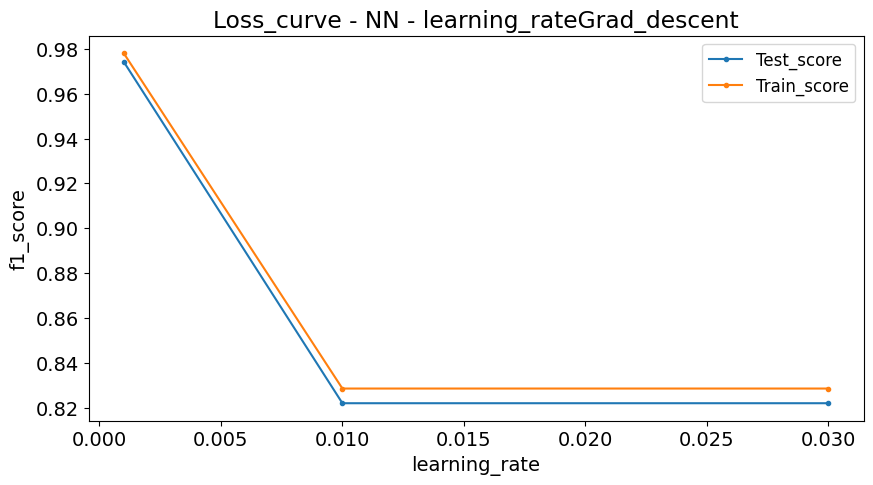

In [103]:

nn_base_params_gd = dict(hidden_nodes = [68,], 
                                 activation = 'relu',
                                learning_rate = 0.001,
                                 algorithm = 'gradient_descent', 
                                 max_iters = 1000,
                                 bias = True, 
                                 is_classifier = True, 
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = seeds[0],
                                 curve = True )

grid_params={'learning_rate': [0.001,0.01,0.03]
             
            }
             
nn_gd_bundle = nn_model_loss_curves(grid_params={'learning_rate': grid_params } ,
                         
                         base_model_params = nn_base_params_gd,
                        model_name = 'Grad_descent')

<Figure size 1000x500 with 0 Axes>

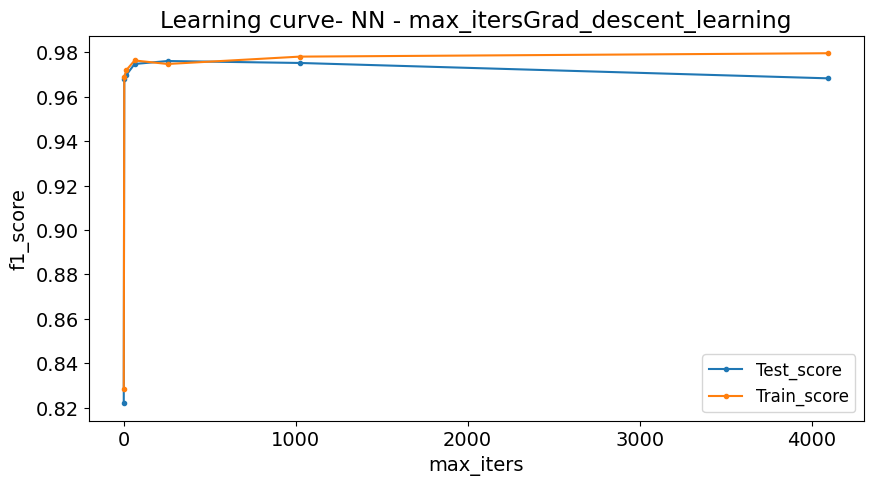

In [108]:

nn_base_params_gd_learning = dict(hidden_nodes = [68,], 
                                 activation = 'relu',
                                learning_rate = 0.001,
                                 algorithm = 'gradient_descent', 
                                 max_iters = 1000,
                                 bias = True, 
                                 is_classifier = True, 
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = seeds[0],
                                 curve = True )


nn_gd_bundle_learning = nn_model_loss_curves(
    grid_params={'max_iters': 4 ** np.arange(7)}
                                     
                                     
                                     ,

                         base_model_params = nn_base_params_gd_learning,
                        model_name = 'Grad_descent_learning',isloss =False)

In [145]:

model_grids = {'random_hill_climb':{
  'learning_rate': [0.001,0.01,0.03],
  'restarts': [1,5, 25, 50,100]},
 
 

 'simulated_annealing' : {
                  'learning_rate': [0.001,0.01,0.03],
                  #'restarts': [1,5, 25, 50,100],
                    'schedule': [GeomDecay(i) for i in [ 0.1 ,  1.   ,5,10,100,300,1000,3000   ]]
                },


'genetic_alg' : {
                      'learning_rate': [0.001,0.01,0.03],
                         'pop_size':[10,20,50,100,200],

                        'mutation_prob' :[0.1,0.3,0.5]
                    }

}



def run_grid(grid):
    

    
    

    nn_base_params = dict(hidden_nodes = [68,], 
                                     activation = 'relu',
                                    learning_rate = 0.001,
                                     algorithm = 'gradient_descent', 
                                     max_iters = 1000,
                                     bias = True, 
                                      restarts = 100,
                                     is_classifier = True, 
                                     early_stopping = True,
                                     max_attempts = 100,
                                     random_state = seeds[0],
                                     curve = True,
                                     schedule = GeomDecay(100),
                                    pop_size = 20,
                                    mutation_prob = 0.5,
                                    clip_max = 10000
                                    
                                         )

    larger_bundelp  = dict()
    for i,j in grid.items():
            
        print('-------',i)
        
        
        
        nn_base_params_copy = nn_base_params
        nn_base_params_copy['algorithm'] = i

        nn_gd_bundle = nn_model_loss_curves(
                                grid_params=j ,

                                 base_model_params = nn_base_params_copy,
                                model_name = i)

        
        

        nn_base_params_gd_learning = nn_gd_bundle['nn_base_params_']

        grid_params={'max_iters': 4 ** np.arange(7)}

        nn_gd_bundle_learning = nn_model_loss_curves(grid_params=grid_params ,

                                 base_model_params = nn_base_params_gd_learning,
                        model_name = i+'learning',isloss =False)
        
        larger_bundelp[i]= dict(loss = nn_gd_bundle,
                                learning = nn_gd_bundle_learning)
        
        
        
        return larger_bundelp

------- random_hill_climb
learning_rate
learning_rate 0.001
learning_rate 0.01
learning_rate 0.03


<Figure size 1000x500 with 0 Axes>

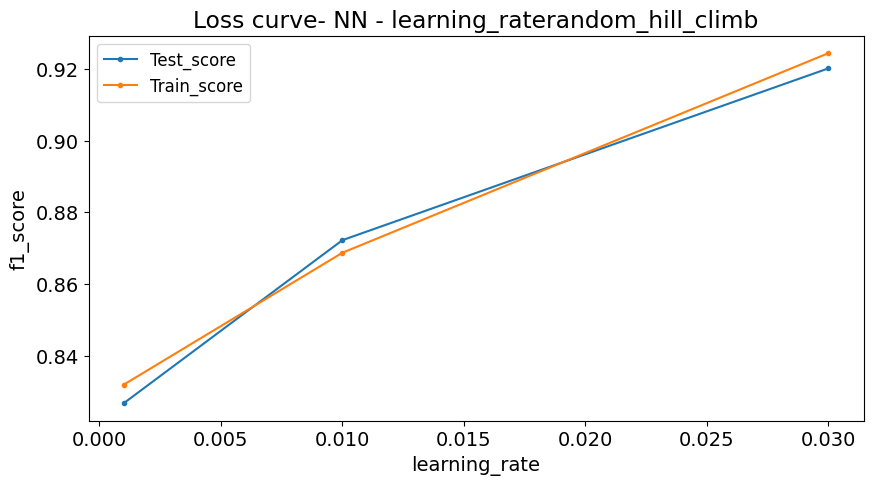

restarts
restarts 1
restarts 5
restarts 25
restarts 50
restarts 100


<Figure size 1000x500 with 0 Axes>

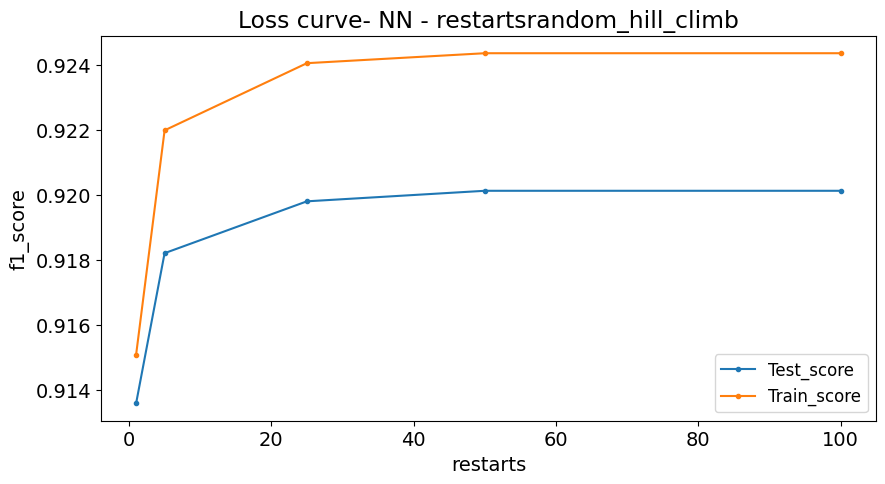

--- learning_rate 0.03
--- restarts 100
{'hidden_nodes': [68], 'activation': 'relu', 'learning_rate': 0.03, 'algorithm': 'random_hill_climb', 'max_iters': 1000, 'bias': True, 'restarts': 100, 'is_classifier': True, 'early_stopping': True, 'max_attempts': 100, 'random_state': 2693, 'curve': True, 'schedule': GeomDecay(init_temp=100, decay=0.99, min_temp=0.001), 'pop_size': 20, 'mutation_prob': 0.5, 'clip_max': 10000}
None None
max_iters
max_iters 1
max_iters 4
max_iters 16
max_iters 64
max_iters 256
max_iters 1024
max_iters 4096


<Figure size 1000x500 with 0 Axes>

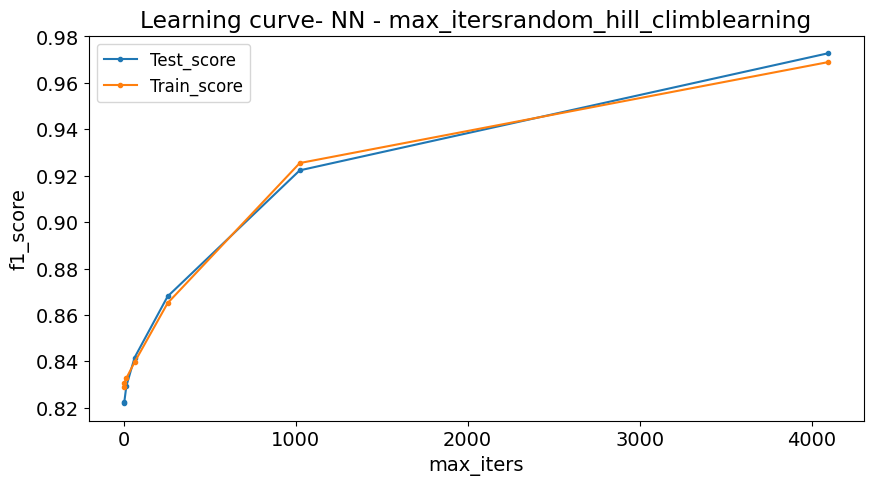

In [148]:

#random_hill_climb
larger_bundelp_rhc = run_grid( {'random_hill_climb':{
  'learning_rate': [0.001,0.01,0.03],
  'restarts': [1,5, 25, 50,100]}}
                         
                         )

------- gradient_descent
learning_rate
learning_rate 0.001
learning_rate 0.01
learning_rate 0.03


<Figure size 1000x500 with 0 Axes>

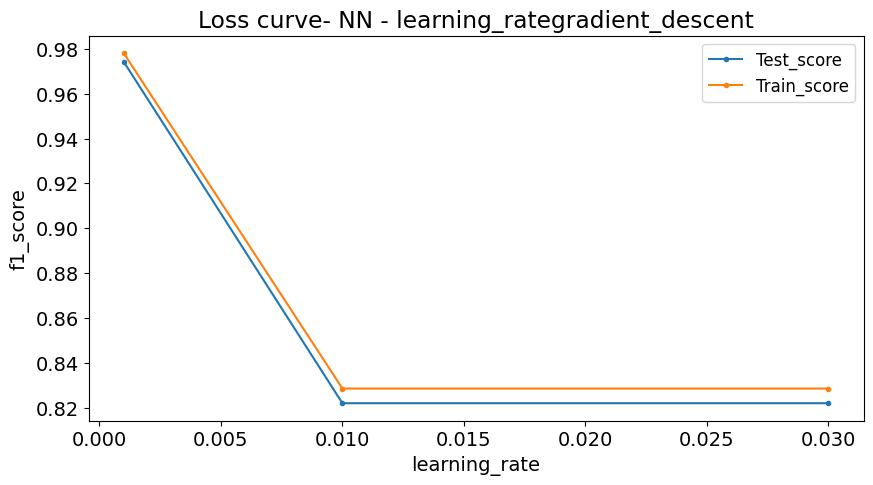

--- learning_rate 0.001
{'hidden_nodes': [68], 'activation': 'relu', 'learning_rate': 0.001, 'algorithm': 'gradient_descent', 'max_iters': 1000, 'bias': True, 'restarts': 100, 'is_classifier': True, 'early_stopping': True, 'max_attempts': 100, 'random_state': 2693, 'curve': True, 'schedule': GeomDecay(init_temp=100, decay=0.99, min_temp=0.001), 'pop_size': 20, 'mutation_prob': 0.5, 'clip_max': 10000}
None None
max_iters
max_iters 1
max_iters 4
max_iters 16
max_iters 64
max_iters 256
max_iters 1024
max_iters 4096


<Figure size 1000x500 with 0 Axes>

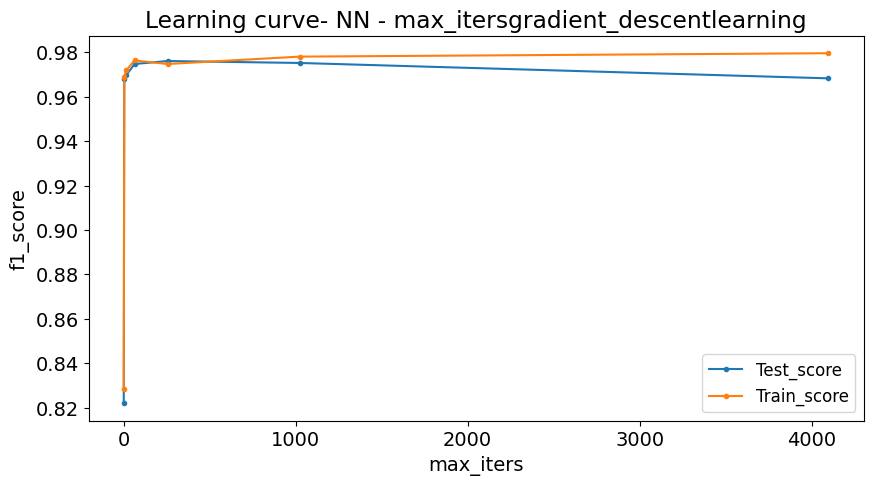

In [149]:
larger_bundelp_gd = run_grid( {'gradient_descent':{
  'learning_rate': [0.001,0.01,0.03]}}
                         
                         )

------- genetic_alg
learning_rate
learning_rate 0.001
learning_rate 0.01
learning_rate 0.03


<Figure size 1000x500 with 0 Axes>

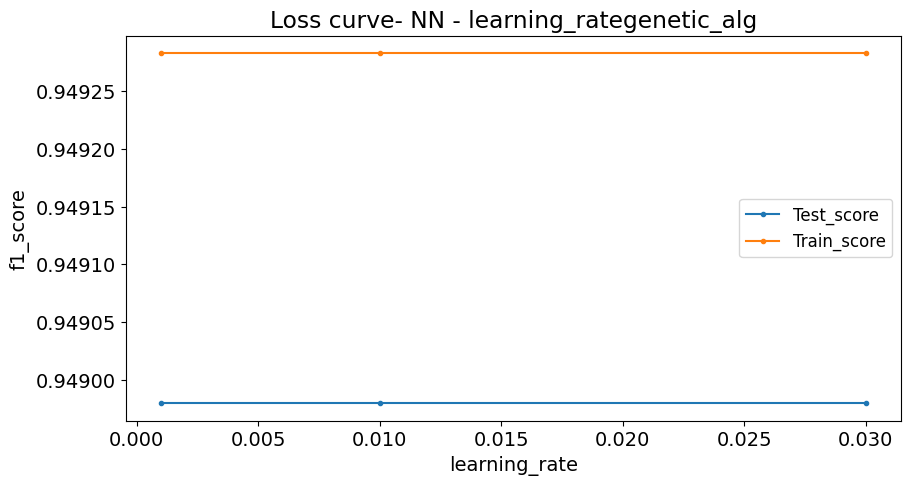

pop_size
pop_size 10
pop_size 20
pop_size 50
pop_size 100
pop_size 200


<Figure size 1000x500 with 0 Axes>

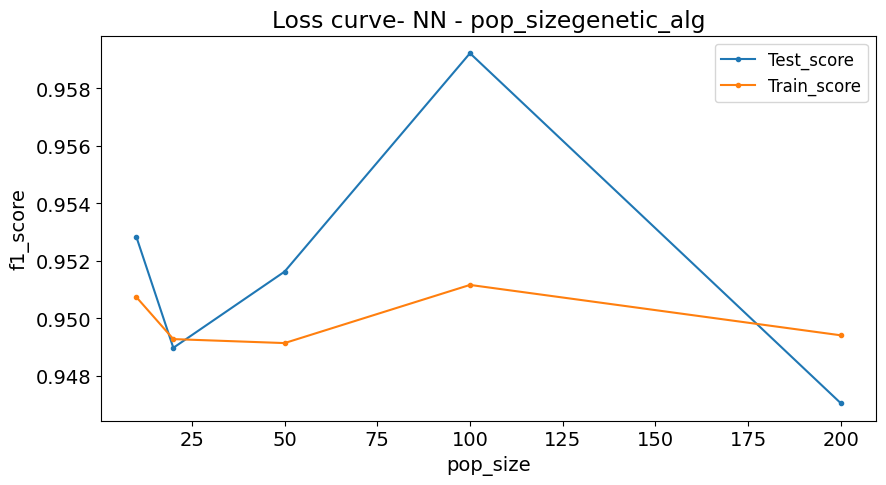

mutation_prob
mutation_prob 0.1
mutation_prob 0.3
mutation_prob 0.5


<Figure size 1000x500 with 0 Axes>

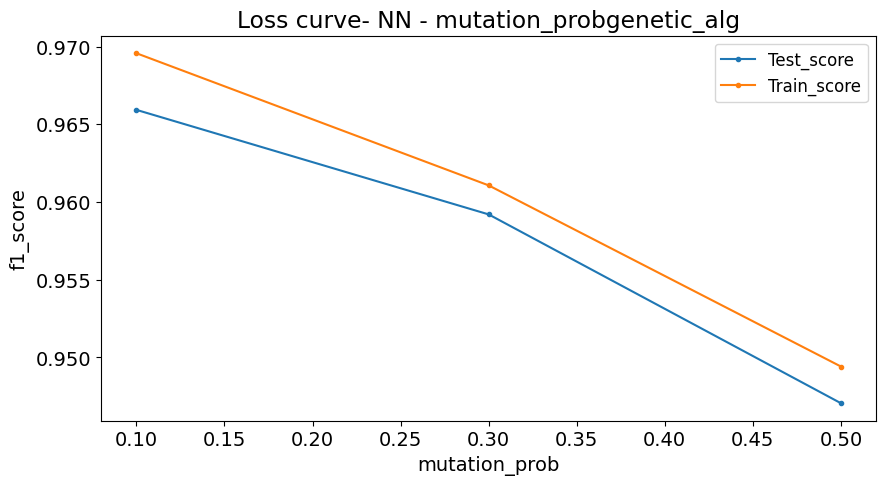

--- learning_rate 0.03
--- pop_size 100
--- mutation_prob 0.1
{'hidden_nodes': [68], 'activation': 'relu', 'learning_rate': 0.03, 'algorithm': 'genetic_alg', 'max_iters': 1000, 'bias': True, 'restarts': 100, 'is_classifier': True, 'early_stopping': True, 'max_attempts': 100, 'random_state': 2693, 'curve': True, 'schedule': GeomDecay(init_temp=100, decay=0.99, min_temp=0.001), 'pop_size': 100, 'mutation_prob': 0.1, 'clip_max': 10000}
None None
max_iters
max_iters 1
max_iters 4
max_iters 16
max_iters 64
max_iters 256
max_iters 1024
max_iters 4096


<Figure size 1000x500 with 0 Axes>

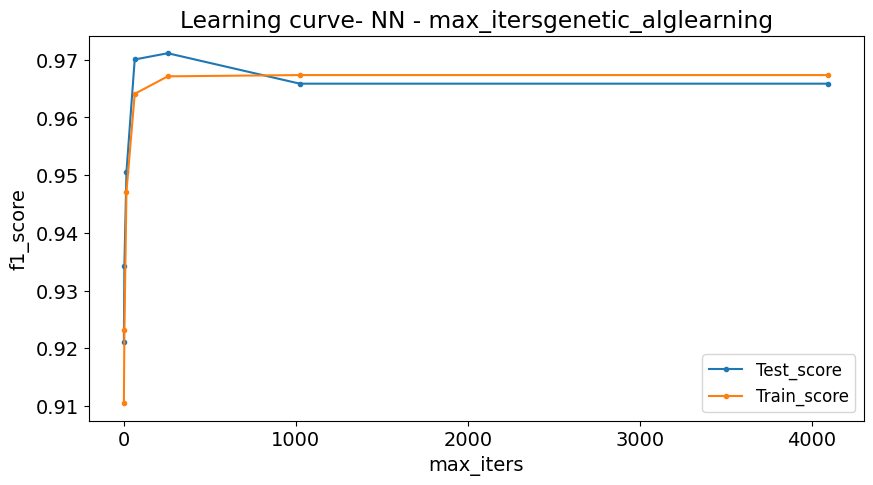

In [150]:
#genetic algorithm
larger_bundel_ga = run_grid( { 'genetic_alg' : {
                      'learning_rate': [0.001,0.01,0.03],
                         'pop_size':[10,20,50,100,200],

                        'mutation_prob' :[0.1,0.3,0.5]
                    }

})

------- simulated_annealing
learning_rate
learning_rate 0.001
learning_rate 0.01
learning_rate 0.03


<Figure size 1000x500 with 0 Axes>

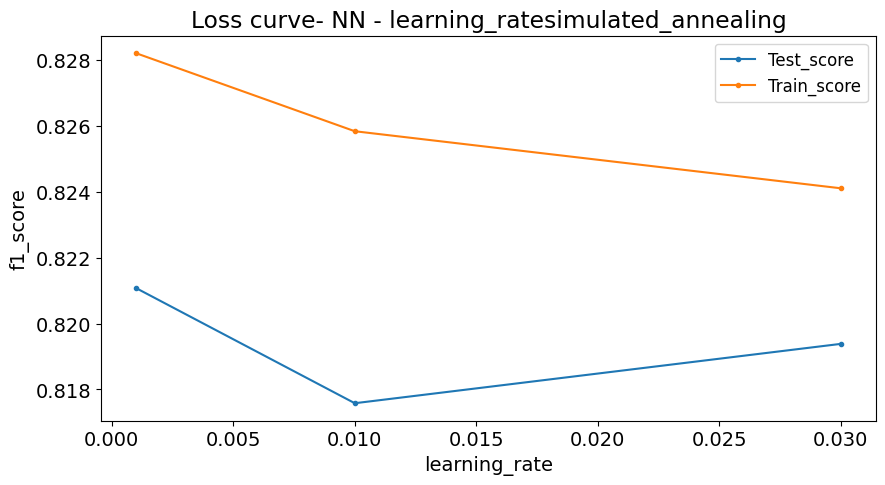

schedule
schedule 0.1
schedule 1.0
schedule 5
schedule 10
schedule 100
schedule 300
schedule 1000
schedule 3000


<Figure size 1000x500 with 0 Axes>

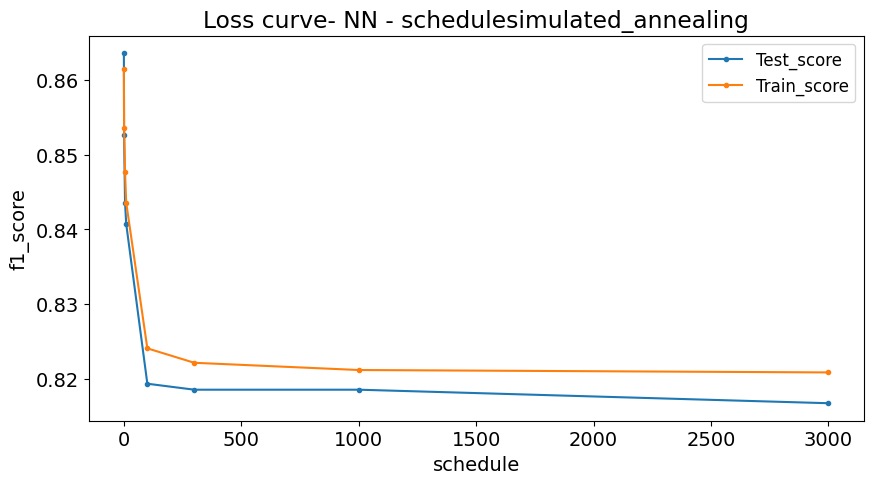

--- learning_rate 0.001
--- schedule 0.1
{'hidden_nodes': [68], 'activation': 'relu', 'learning_rate': 0.001, 'algorithm': 'simulated_annealing', 'max_iters': 1000, 'bias': True, 'restarts': 100, 'is_classifier': True, 'early_stopping': True, 'max_attempts': 100, 'random_state': 2693, 'curve': True, 'schedule': GeomDecay(init_temp=0.1, decay=0.99, min_temp=0.001), 'pop_size': 20, 'mutation_prob': 0.5, 'clip_max': 10000}
None None
max_iters
max_iters 1
max_iters 4
max_iters 16
max_iters 64
max_iters 256
max_iters 1024
max_iters 4096


<Figure size 1000x500 with 0 Axes>

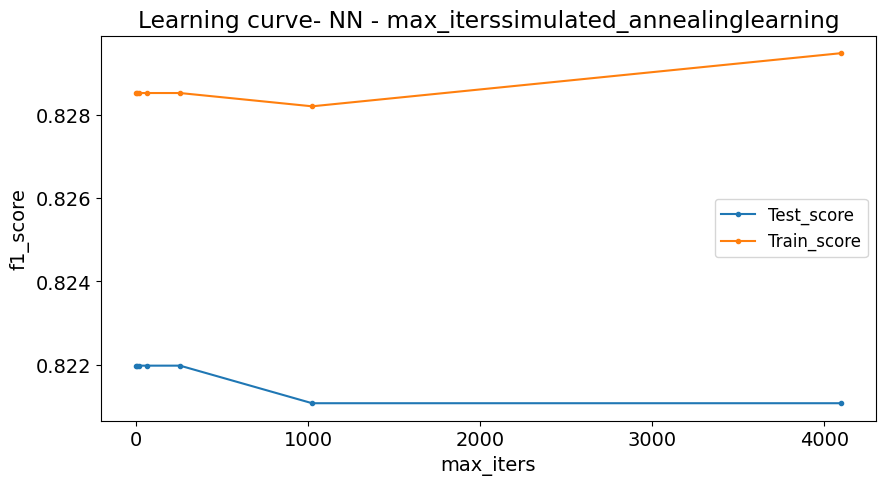

In [147]:
#Simulated annealing
larger_bundelp = run_grid( { 'simulated_annealing' : {
                  'learning_rate': [0.001,0.01,0.03],
                  #'restarts': [1,5, 25, 50,100],
                    'schedule': [GeomDecay(i) for i in [ 0.1 ,  1. ,5,10,100,300,1000,3000   ]]
                },


#'genetic_alg' : {
#                      'learning_rate': [0.001,0.01,0.03],
#                         'pop_size':[10,20,50,100,200],

#                        'mutation_prob' :[0.1,0.3,0.5]
#                    }

})

<Figure size 1000x500 with 0 Axes>

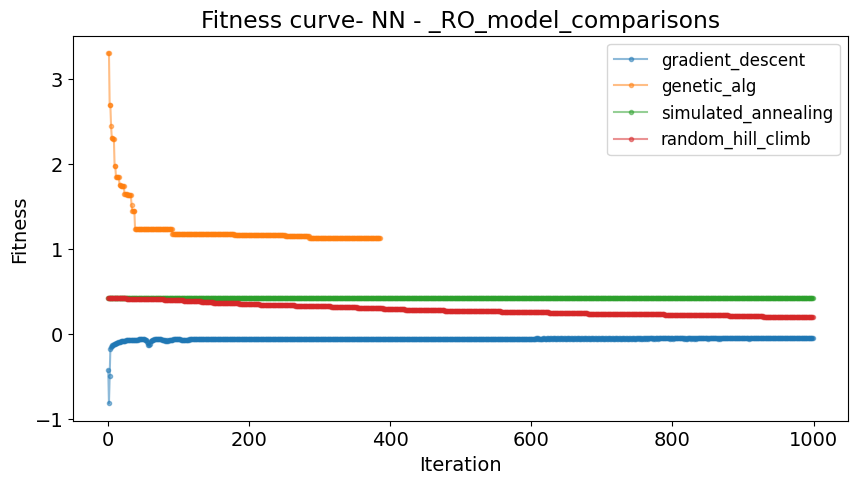

In [193]:
#Fitness leanring function
ro_list = ['gradient_descent','random_hill_climb', 'simulated_annealing', 'genetic_alg']


Fitness_curve = pd.DataFrame()


Fitness_curve['gradient_descent'] = pd.DataFrame(larger_bundelp_gd['gradient_descent']['loss']['best_model']['model'].fitness_curve)

Fitness_curve['genetic_alg'] = pd.DataFrame(larger_bundel_ga['genetic_alg']['loss']['best_model']['model'].fitness_curve)[[0]]


Fitness_curve['simulated_annealing'] = pd.DataFrame(larger_bundelp['simulated_annealing']['loss']['best_model']['model'
                                                                        ].fitness_curve)[[0]]


Fitness_curve['random_hill_climb'] = pd.DataFrame(larger_bundelp_rhc['random_hill_climb']['loss']['best_model']['model'].fitness_curve)[[0]]
    
Fitness_curve.to_csv('agg_tables/NN_best_models_Fitness_curve.csv')    
    



plt.figure()

title = 'Fitness curve' +'- NN - '+'_RO_model_comparisons'

Fitness_curve.plot(marker = '.', title = title,fontsize = 14,alpha = 0.5)

#loss_curves[i].set_index('Param_val')[['Test_score','Train_score']].plot(marker = '.',

#                                                             title = title,
#                                                              fontsize = 14

#                                                             )

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Fitness',fontsize = 14)
plt.legend(fontsize = 12)
plt.savefig(r'figure//'+title+'.png',bbox_inches ='tight')
plt.show()



# F1 learning curve

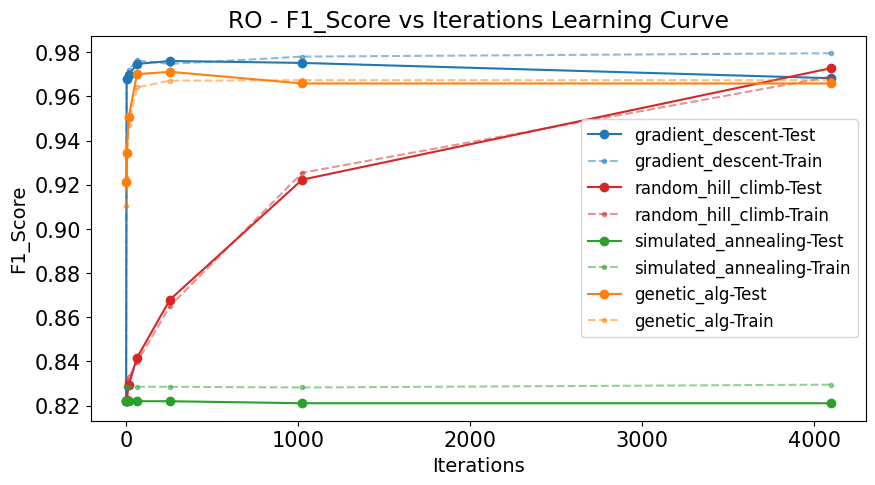

In [253]:
color_map = {'gradient_descent':'tab:blue',
'random_hill_climb':'tab:red', 
'simulated_annealing':'tab:green',
'genetic_alg':'tab:orange'}


data_s = dict({})

fig,ax = plt.subplots()

legends = []

for i in ['gradient_descent',
'random_hill_climb', 
'simulated_annealing',
'genetic_alg']:
    data_s[i] = pd.read_csv('agg_tables/NN_learning_curves/'+i+'learning_max_iters.csv')
    data_s[i]['algo'] = i
    data_s[i].set_index('Param_val',inplace = True)
    
    bx = data_s[i]['Test_score'].plot(ax=ax,color=color_map[i],marker = 'o')
    #fig.legend(i+'-Test')
    cx = data_s[i]['Train_score'].plot(ax=ax,color=color_map[i],linestyle='--',marker = '.',alpha = 0.5)
    
    legends.extend([i+'-Test',i+'-Train'])
    
cx.legend(legends,fontsize=12)
    
plt.ylabel('F1_Score')
plt.xlabel('Iterations')

titles = 'RO - F1_Score vs Iterations Learning Curve'

plt.title(titles)
plt.savefig(r'figure//'+title+'.png',bbox_inches ='tight')
plt.show()